# Distance Estimation and Angle Recovery

TODO: put equateions

## Content

1. [Data Preparation](Read-Data)
2. 

## Read Data

Data used:
- Protein: 5j0n (symmetric protein)
- Projections: 5K
- Coverage: Half-sphere

![](figures/5j0n.pdb1-500.jpg)

In [1]:
import os
import h5py
import numpy as np

import sys
sys.path.append("../..") 
from cryoem.plots import plot_angles_count, plot_euclidean_space, save_space_plot, plot_SO3_space, plot_selected_angles_with_3rd_angle_magnitude
from IPython.display import Image
from cryoem.angle_recovery import train_angle_recovery

import tensorflow as tf
from cryoem.quaternions import d_q, euler2quaternion
from cryoem.plots import plot_dP_dQ,plot_dP_dQ_density,plot_only_selected_in_euclidean_space, plot_rays, plot_images
from cryoem.angle_recovery import geodesic_distance, update_angles, distance_difference, find_best_rotation
from cryoem.distance_estimation import train_siamese
import ipyvolume as ipv

In [2]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 17666401790754844415
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 5605362582906475396
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 15353226359772026292
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_GPU:1"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 1092828457501819078
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 222756864
locality {
  bus_id: 1
  links {
    link {
      device_id: 1
      type: "StreamExecutor"
      strength: 1
    }
  }
}
incarnation: 9624200515041521667
physical_device_desc: "device: 0, name: Tesla K40c, pci bus id: 0000:3b:00.0, compute capability: 3.5"
, name: "/device:GPU:1"
device_type: "GPU"
memory_l

In [3]:
PROTEIN="5j0n"#"5a1a"
ROOT_DIR = "../.."
NUM_PROJECTIONS = 5000

In [4]:
# location of *.h5 files
data_dir = f"{ROOT_DIR}/data"

# half coverage (AngCoverage=0.5)
projections_filename = f"{PROTEIN}_ProjectionsAngles_ProjNber5000_AngCoverage2.0,0.4,2.0_AngShift0.0,0.0,0.0.h5"

# load structures
data = h5py.File(os.path.join(data_dir, projections_filename), 'r')

print(f"{data['Projections'].shape[0]} projections of images with dimension {data['Projections'].shape[1:]} pixels")
print(f"{data['Angles'].shape[0]} sets of {data['Angles'].shape[1]} ground truth angles of corresponding projection images")

5000 projections of images with dimension (116, 116) pixels
5000 sets of 3 ground truth angles of corresponding projection images


### True Angles

In [5]:
angles_true = np.array(data['Angles'])
angles_true.shape

(5000, 3)

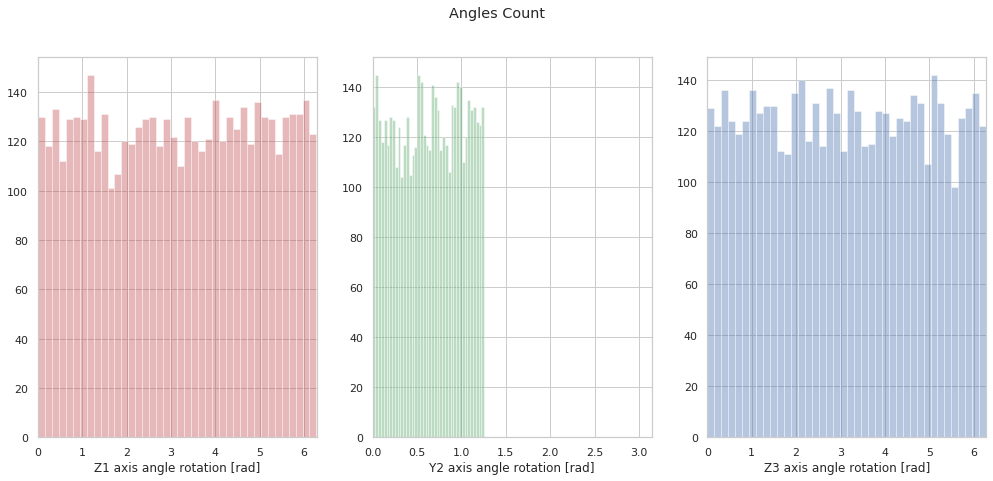

In [6]:
plot_angles_count(angles_true)

---

## Prepare for training

In [7]:
from sklearn.model_selection import train_test_split
from cryoem.distance_estimation import create_pairs

In [8]:
X, y = np.array(data['Projections'], dtype=np.float32), np.array(data['Angles'], dtype=np.float32)

In [9]:
# the data, split between train and test sets
train_idx, test_idx = train_test_split(range(NUM_PROJECTIONS), 
                                       test_size=0.33, 
                                       random_state=42)
train_idx, val_idx= train_test_split(train_idx, 
                                     test_size=0.25, 
                                     random_state=1)

train_idx = sorted(train_idx)
val_idx = sorted(val_idx)
test_idx = sorted(test_idx)

In [10]:
# TODO: 2 problems, bigger image now it is 275 instead of 116
# and the tr_pairs bellow the number is a lot decreased

In [11]:
# TODO: increase these values, it is just important to have the batches small enough
tr_pairs, tr_y = create_pairs(X, y, indices=train_idx, num_pairs=6000)
tr_pairs = tr_pairs.reshape(list(tr_pairs.shape) + [-1])
tr_y = tf.cast(tr_y, dtype=tf.float32)

val_pairs, val_y = create_pairs(X, y, indices=val_idx, num_pairs=2000)
val_pairs = val_pairs.reshape(list(val_pairs.shape) + [-1])
val_y = tf.cast(val_y, dtype=tf.float32)

te_pairs, te_y = create_pairs(X, y, indices=test_idx, num_pairs=2000)
te_pairs = te_pairs.reshape(list(te_pairs.shape) + [-1])
te_y = tf.cast(te_y, dtype=tf.float32)

# 1. Distance Estimation

### Train the model

Input images shape (116, 116, 1)
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 116, 116, 1) 0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 116, 116, 1) 0                                            
__________________________________________________________________________________________________
model (Model)                   (None, 256)          159744      input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 1)            0     

Epoch 25/500
59904/60000 [============================>.] - ETA: 0s - loss: 0.0818 - mae: 0.2330
Epoch 00025: saving model to training/20200220_132435
60000/60000 [==============================] - 121s 2ms/sample - loss: 0.0818 - mae: 0.2331 - val_loss: 0.0997 - val_mae: 0.2556
Epoch 26/500
59904/60000 [============================>.] - ETA: 0s - loss: 0.0801 - mae: 0.2304
Epoch 00026: saving model to training/20200220_132435
60000/60000 [==============================] - 121s 2ms/sample - loss: 0.0801 - mae: 0.2304 - val_loss: 0.0993 - val_mae: 0.2555
Epoch 27/500
59904/60000 [============================>.] - ETA: 0s - loss: 0.0785 - mae: 0.2279
Epoch 00027: saving model to training/20200220_132435
60000/60000 [==============================] - 121s 2ms/sample - loss: 0.0785 - mae: 0.2279 - val_loss: 0.0971 - val_mae: 0.2525
Epoch 28/500
59904/60000 [============================>.] - ETA: 0s - loss: 0.0771 - mae: 0.2259
Epoch 00028: saving model to training/20200220_132435
60000/600

59904/60000 [============================>.] - ETA: 0s - loss: 0.0499 - mae: 0.1810
Epoch 00083: saving model to training/20200220_132435
60000/60000 [==============================] - 121s 2ms/sample - loss: 0.0499 - mae: 0.1810 - val_loss: 0.0777 - val_mae: 0.2253
Epoch 84/500
59904/60000 [============================>.] - ETA: 0s - loss: 0.0493 - mae: 0.1801
Epoch 00084: saving model to training/20200220_132435
60000/60000 [==============================] - 121s 2ms/sample - loss: 0.0493 - mae: 0.1801 - val_loss: 0.0759 - val_mae: 0.2231
Epoch 85/500
59904/60000 [============================>.] - ETA: 0s - loss: 0.0492 - mae: 0.1799
Epoch 00085: saving model to training/20200220_132435
60000/60000 [==============================] - 120s 2ms/sample - loss: 0.0492 - mae: 0.1799 - val_loss: 0.0758 - val_mae: 0.2193
Epoch 86/500
59904/60000 [============================>.] - ETA: 0s - loss: 0.0492 - mae: 0.1798
Epoch 00086: saving model to training/20200220_132435
60000/60000 [=========

59904/60000 [============================>.] - ETA: 0s - loss: 0.0424 - mae: 0.1658
Epoch 00141: saving model to training/20200220_132435
60000/60000 [==============================] - 120s 2ms/sample - loss: 0.0424 - mae: 0.1658 - val_loss: 0.0731 - val_mae: 0.2192
Epoch 142/500
59904/60000 [============================>.] - ETA: 0s - loss: 0.0423 - mae: 0.1655
Epoch 00142: saving model to training/20200220_132435
60000/60000 [==============================] - 121s 2ms/sample - loss: 0.0423 - mae: 0.1655 - val_loss: 0.0725 - val_mae: 0.2123
Epoch 143/500
59904/60000 [============================>.] - ETA: 0s - loss: 0.0425 - mae: 0.1656
Epoch 00143: saving model to training/20200220_132435
60000/60000 [==============================] - 121s 2ms/sample - loss: 0.0425 - mae: 0.1656 - val_loss: 0.0715 - val_mae: 0.2119
Epoch 144/500
59904/60000 [============================>.] - ETA: 0s - loss: 0.0421 - mae: 0.1651
Epoch 00145: saving model to training/20200220_132435
60000/60000 [======

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



59904/60000 [============================>.] - ETA: 0s - loss: 0.0396 - mae: 0.1593
Epoch 00190: saving model to training/20200220_132435
60000/60000 [==============================] - 121s 2ms/sample - loss: 0.0396 - mae: 0.1593 - val_loss: 0.0699 - val_mae: 0.2104
Epoch 191/500
59904/60000 [============================>.] - ETA: 0s - loss: 0.0398 - mae: 0.1594
Epoch 00191: saving model to training/20200220_132435
60000/60000 [==============================] - 121s 2ms/sample - loss: 0.0398 - mae: 0.1594 - val_loss: 0.0715 - val_mae: 0.2103
Epoch 192/500
59904/60000 [============================>.] - ETA: 0s - loss: 0.0394 - mae: 0.1588
Epoch 00192: saving model to training/20200220_132435
60000/60000 [==============================] - 121s 2ms/sample - loss: 0.0394 - mae: 0.1588 - val_loss: 0.0708 - val_mae: 0.2093
Epoch 193/500
59904/60000 [============================>.] - ETA: 0s - loss: 0.0397 - mae: 0.1594
Epoch 00193: saving model to training/20200220_132435
60000/60000 [======

59904/60000 [============================>.] - ETA: 0s - loss: 0.0375 - mae: 0.1542
Epoch 00248: saving model to training/20200220_132435
60000/60000 [==============================] - 121s 2ms/sample - loss: 0.0375 - mae: 0.1542 - val_loss: 0.0697 - val_mae: 0.2093
Epoch 249/500
59904/60000 [============================>.] - ETA: 0s - loss: 0.0378 - mae: 0.1546
Epoch 00249: saving model to training/20200220_132435
60000/60000 [==============================] - 121s 2ms/sample - loss: 0.0378 - mae: 0.1546 - val_loss: 0.0703 - val_mae: 0.2122
Epoch 250/500
59904/60000 [============================>.] - ETA: 0s - loss: 0.0376 - mae: 0.1544
Epoch 00250: saving model to training/20200220_132435
60000/60000 [==============================] - 121s 2ms/sample - loss: 0.0376 - mae: 0.1544 - val_loss: 0.0689 - val_mae: 0.2107
Epoch 251/500
59904/60000 [============================>.] - ETA: 0s - loss: 0.0379 - mae: 0.1548
Epoch 00251: saving model to training/20200220_132435
60000/60000 [======

59904/60000 [============================>.] - ETA: 0s - loss: 0.0366 - mae: 0.1518
Epoch 00306: saving model to training/20200220_132435
60000/60000 [==============================] - 120s 2ms/sample - loss: 0.0366 - mae: 0.1518 - val_loss: 0.0693 - val_mae: 0.2088
Epoch 307/500
59904/60000 [============================>.] - ETA: 0s - loss: 0.0365 - mae: 0.1515
Epoch 00307: saving model to training/20200220_132435
60000/60000 [==============================] - 120s 2ms/sample - loss: 0.0365 - mae: 0.1515 - val_loss: 0.0691 - val_mae: 0.2082
Epoch 308/500
59904/60000 [============================>.] - ETA: 0s - loss: 0.0365 - mae: 0.1516
Epoch 00308: saving model to training/20200220_132435
60000/60000 [==============================] - 120s 2ms/sample - loss: 0.0365 - mae: 0.1516 - val_loss: 0.0696 - val_mae: 0.2095
Epoch 309/500
59904/60000 [============================>.] - ETA: 0s - loss: 0.0366 - mae: 0.1517
Epoch 00309: saving model to training/20200220_132435
60000/60000 [======

59904/60000 [============================>.] - ETA: 0s - loss: 0.0356 - mae: 0.1495
Epoch 00364: saving model to training/20200220_132435
60000/60000 [==============================] - 120s 2ms/sample - loss: 0.0356 - mae: 0.1495 - val_loss: 0.0694 - val_mae: 0.2078
Epoch 365/500
59904/60000 [============================>.] - ETA: 0s - loss: 0.0358 - mae: 0.1497
Epoch 00365: saving model to training/20200220_132435
60000/60000 [==============================] - 121s 2ms/sample - loss: 0.0358 - mae: 0.1497 - val_loss: 0.0691 - val_mae: 0.2081
Epoch 366/500
59904/60000 [============================>.] - ETA: 0s - loss: 0.0358 - mae: 0.1497
Epoch 00366: saving model to training/20200220_132435
60000/60000 [==============================] - 120s 2ms/sample - loss: 0.0358 - mae: 0.1497 - val_loss: 0.0701 - val_mae: 0.2076
Epoch 367/500
59904/60000 [============================>.] - ETA: 0s - loss: 0.0356 - mae: 0.1491
Epoch 00367: saving model to training/20200220_132435
60000/60000 [======

59904/60000 [============================>.] - ETA: 0s - loss: 0.0351 - mae: 0.1480
Epoch 00422: saving model to training/20200220_132435
60000/60000 [==============================] - 121s 2ms/sample - loss: 0.0351 - mae: 0.1480 - val_loss: 0.0694 - val_mae: 0.2081
Epoch 423/500
59904/60000 [============================>.] - ETA: 0s - loss: 0.0351 - mae: 0.1480
Epoch 00423: saving model to training/20200220_132435
60000/60000 [==============================] - 121s 2ms/sample - loss: 0.0351 - mae: 0.1479 - val_loss: 0.0706 - val_mae: 0.2091
Epoch 424/500
59904/60000 [============================>.] - ETA: 0s - loss: 0.0349 - mae: 0.1474
Epoch 00424: saving model to training/20200220_132435
60000/60000 [==============================] - 121s 2ms/sample - loss: 0.0349 - mae: 0.1475 - val_loss: 0.0699 - val_mae: 0.2091
Epoch 425/500
59904/60000 [============================>.] - ETA: 0s - loss: 0.0351 - mae: 0.1480
Epoch 00425: saving model to training/20200220_132435
60000/60000 [======

59904/60000 [============================>.] - ETA: 0s - loss: 0.0346 - mae: 0.1466
Epoch 00480: saving model to training/20200220_132435
60000/60000 [==============================] - 121s 2ms/sample - loss: 0.0346 - mae: 0.1466 - val_loss: 0.0702 - val_mae: 0.2083
Epoch 481/500
59904/60000 [============================>.] - ETA: 0s - loss: 0.0347 - mae: 0.1469
Epoch 00481: saving model to training/20200220_132435
60000/60000 [==============================] - 121s 2ms/sample - loss: 0.0347 - mae: 0.1469 - val_loss: 0.0731 - val_mae: 0.2104
Epoch 482/500
59904/60000 [============================>.] - ETA: 0s - loss: 0.0346 - mae: 0.1469
Epoch 00482: saving model to training/20200220_132435
60000/60000 [==============================] - 120s 2ms/sample - loss: 0.0346 - mae: 0.1468 - val_loss: 0.0726 - val_mae: 0.2088
Epoch 483/500
59904/60000 [============================>.] - ETA: 0s - loss: 0.0347 - mae: 0.1466
Epoch 00483: saving model to training/20200220_132435
60000/60000 [======

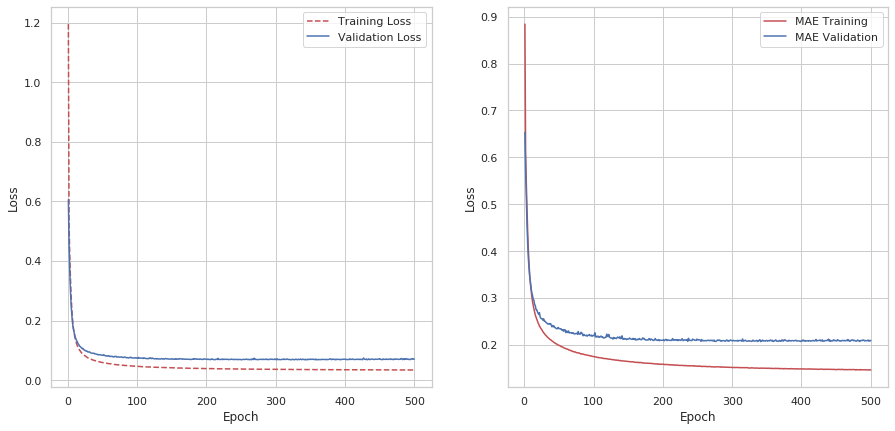

In [15]:
model = train_siamese(training_pairs=tr_pairs, 
              training_y=tr_y, 
              validation_pairs=val_pairs, 
              validation_y=val_y, 
              epochs=500, 
              batch_size=256, 
              learning_rate=0.0001,
              plot=True)

### (Or) Read model checkpoint

In [13]:
# stop here, change file

In [12]:
# #model_filename = "training/20191218_023743.h5"

# On LTS: "training/20200221_061000.h5"
model_filename = "training/20200220_055622.h5"

In [13]:
# Recreate the exact same model, including its weights and the optimizer
model = tf.keras.models.load_model(model_filename)

# Show the model architecture
model.summary()

OSError: SavedModel file does not exist at: training/20200220_055622.h5/{saved_model.pbtxt|saved_model.pb}

### Some model results

In [14]:
from cryoem.distance_estimation import plot_results

In [20]:
y_tr_pred = model.predict_on_batch([tr_pairs[:256, 0], tr_pairs[:256, 1]])
y_val_pred = model.predict_on_batch([val_pairs[:256, 0], val_pairs[:256, 1]])

In [21]:
plot_train_results = plot_results(tr_pairs, y_tr_pred, tr_y, "Train")
plot_validation_results = plot_results(val_pairs, y_val_pred, val_y, "Validation")

--- Train Set ---
predicted: 1.3596973419189453
true:      1.3008451461791992
mse:       0.003463580971583724
mae:       0.058852195739746094


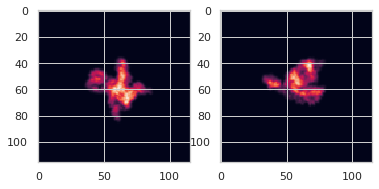

In [22]:
plot_train_results(1)

--- Validation Set ---
predicted: 2.1138882637023926
true:      2.1860225200653076
mse:       0.00520335091277957
mae:       0.07213425636291504


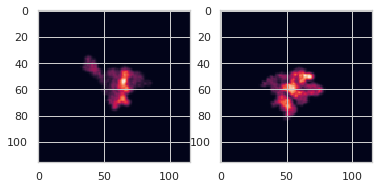

In [23]:
plot_validation_results(0)

---

## dP/dQ plot

In [24]:
from cryoem.quaternions import d_q, euler2quaternion
from cryoem.plots import plot_dP_dQ,plot_dP_dQ_density

In [25]:
def d_p(p1, p2):
    p1 = tf.convert_to_tensor(p1)
    p1 = tf.expand_dims(p1, len(p1.shape)) 
    p2 = tf.convert_to_tensor(p2)
    p2 = tf.expand_dims(p2, len(p2.shape)) 
    return model.predict_on_batch([p1, p2])

In [26]:
idx1 = list(np.random.choice(range(NUM_PROJECTIONS), size=256))
idx2 = list(np.random.choice(range(NUM_PROJECTIONS), size=256))

q1_true = euler2quaternion([angles_true[i] for i in idx1])
q2_true = euler2quaternion([angles_true[i] for i in idx2])

p1 = [X[i] for i in idx1]
p2 = [X[i] for i in idx2]

dP_values = d_p(p1, p2).numpy().T[0]
dQ_values = d_q(q1_true, q2_true).numpy()

<Figure size 432x288 with 0 Axes>

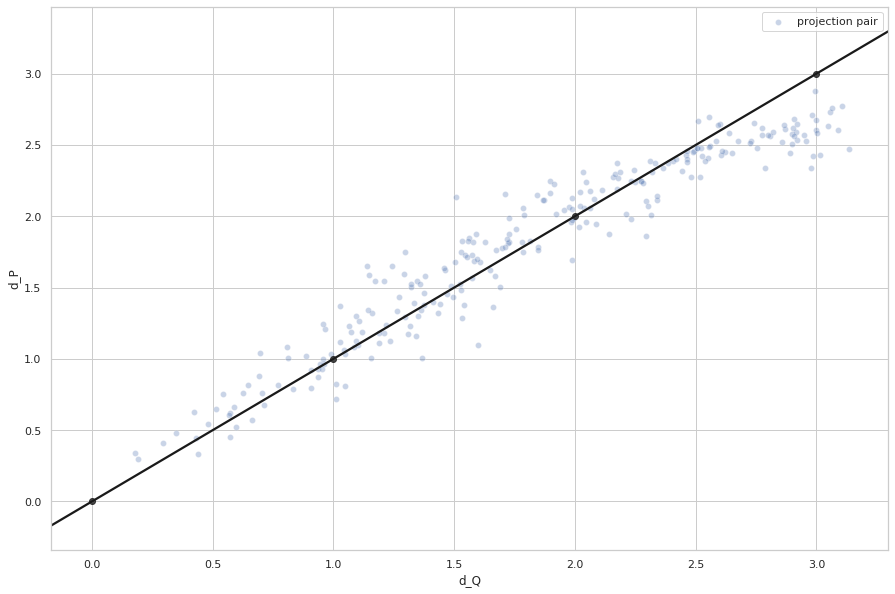

In [27]:
plot_dP_dQ(dP_values, dQ_values)

<Figure size 432x288 with 0 Axes>

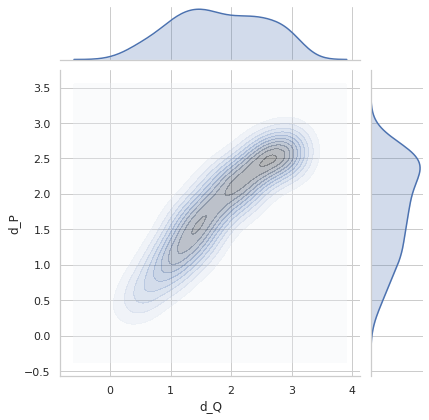

In [28]:
plot_dP_dQ_density(dP_values, dQ_values)

In [29]:
np.sqrt(1/(len(dQ_values)-1)*np.sum(np.power(dP_values-dQ_values, 2)))

0.2153082007138402

# 2. Angle Recovery

In [30]:
from cryoem.angle_recovery import train_angle_recovery

###### Predicted Angles (initialization)

In [31]:
angle_shift = [0.0, 0.0, 0.0]
angle_coverage = [2.0, 0.4, 2.0]

low_ang = [x*np.pi for x in angle_shift]
high_ang = [x*np.pi for x in angle_coverage]

euler = np.random.uniform(low=[low_ang[0], low_ang[1], low_ang[2]], 
                          high=[high_ang[0], high_ang[1], high_ang[2]],
                          size=(len(angles_true), 3))

# angles_predicted = [tf.Variable(e, constraint=lambda x: mod_angles(x, angle_shift, angle_coverage)) for e in euler]
angles_predicted = [tf.Variable(e, dtype=tf.float32) for e in euler]


angles_predicted = np.array(angles_predicted)
angles_predicted.shape

(5000,)

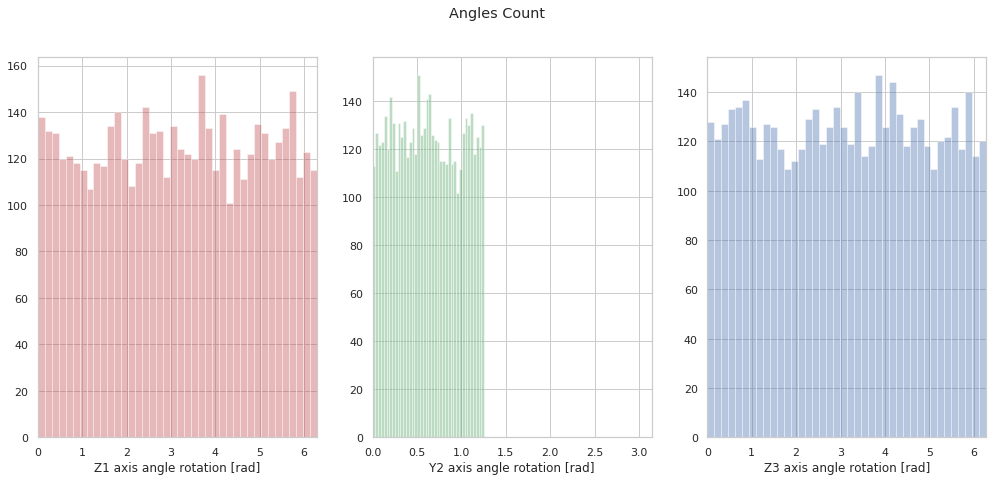

In [32]:
plot_angles_count(angles_predicted)

## Angle Recovery

Perfect distances. Learning rate 0.01

In [33]:
from cryoem.angle_recovery import train_angle_recovery

step 15000/150000 (7022s): loss = 9.34e-01
step 30000/150000 (14614s): loss = 7.61e-01
step 45000/150000 (21230s): loss = 7.79e-01
step 60000/150000 (27929s): loss = 7.17e-01
step 75000/150000 (34692s): loss = 7.95e-01
step 90000/150000 (41438s): loss = 8.00e-01
step 105000/150000 (47778s): loss = 7.66e-01
step 120000/150000 (54142s): loss = 7.38e-01
step 135000/150000 (60519s): loss = 7.41e-01
step 150000/150000 (66894s): loss = 8.63e-01


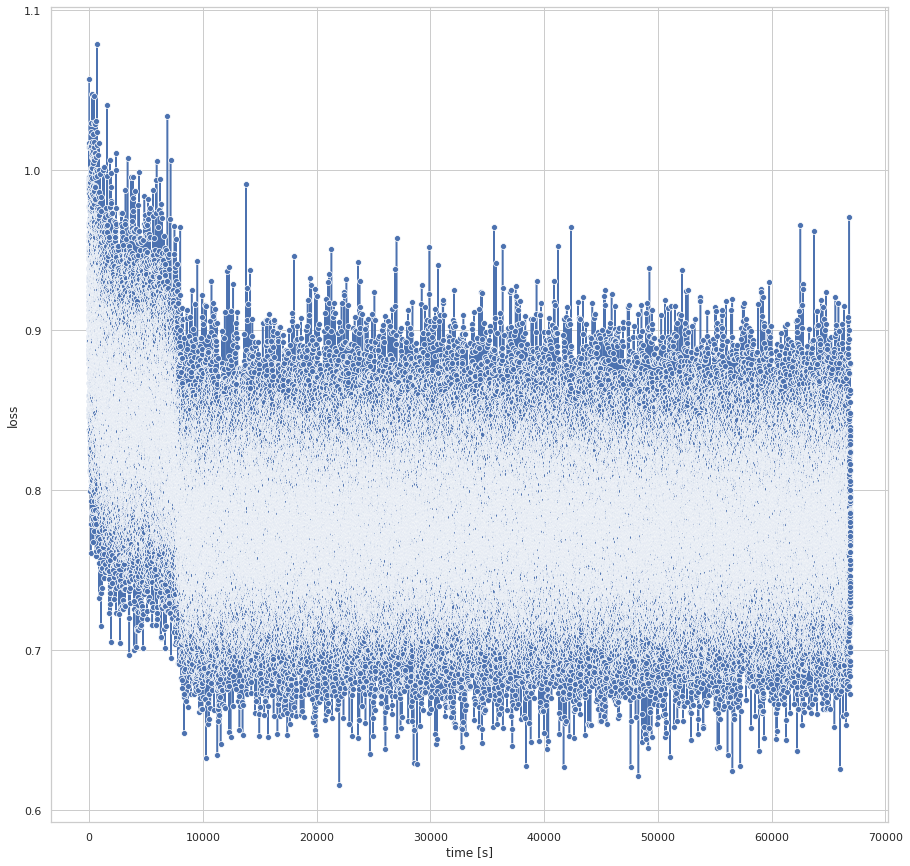

In [35]:
train_angle_recovery(steps=150000, 
                     batch_size=256, 
                     projection_idx=test_idx, 
                     angles_predicted=angles_predicted, 
                     est_dist_input=X, 
                     est_dist=d_p, 
                     learning_rate=0.01, 
                     optimization=True)

In [37]:
ang_save = np.zeros((len(angles_predicted),3))
for i, a in enumerate(angles_predicted):
    ang_save[i] = a.numpy()
                    
np.save("data/predicted_angles_siamese1.npy", ang_save)

In [6]:

#ap_mod = np.load("predicted_angles_mod.npy")
ap = np.load("data/predicted_angles_siamese1.npy")

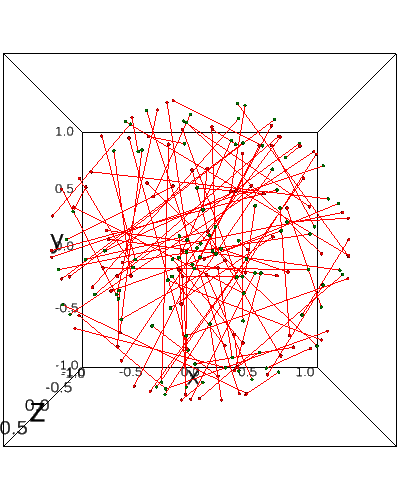

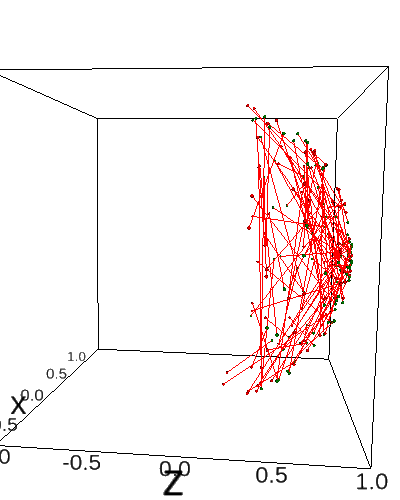

In [7]:
plot_only_selected_in_euclidean_space(ap, angles_true, range(100))

In [9]:
display(ipv.screenshot())

Output()

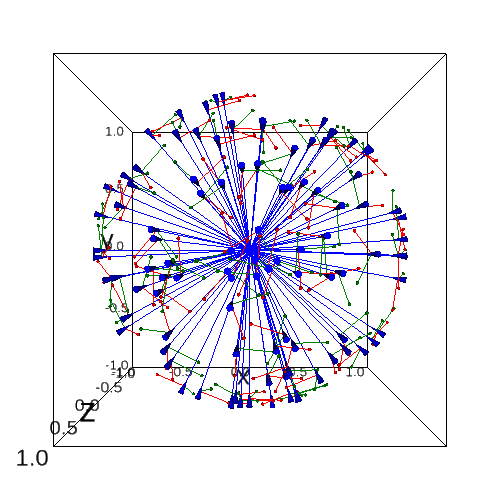

In [10]:
plot_rays(ap, indices=range(100))

In [11]:
display(ipv.screenshot())

Output()

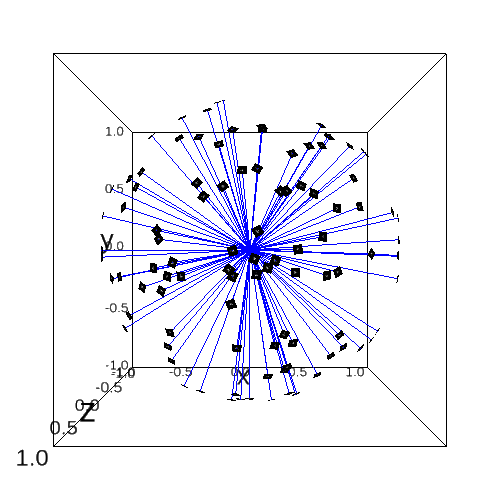

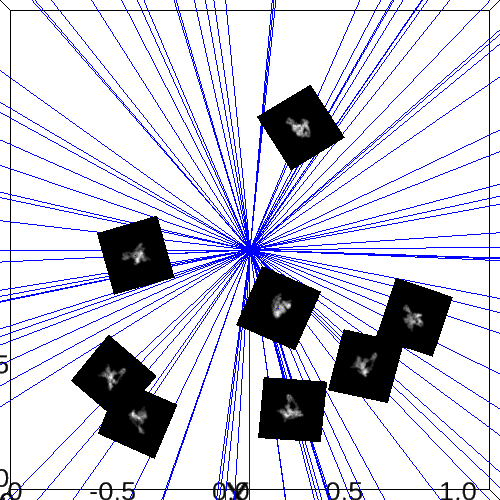

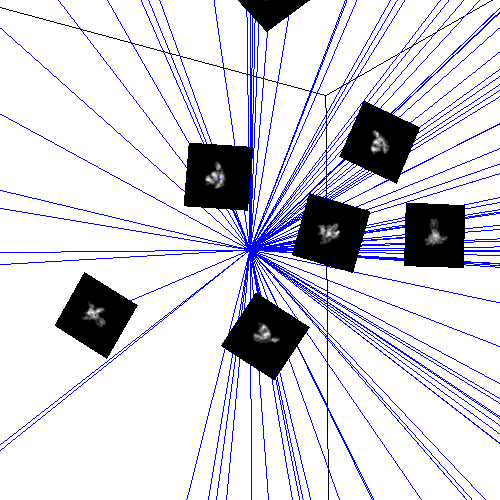

In [16]:
plot_images(ap, data['Projections'], indices=range(100),img_size_scale=0.05)

In [19]:
display(ipv.screenshot())

Output()

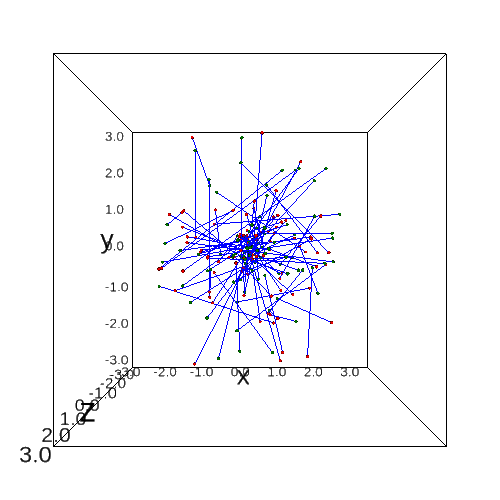

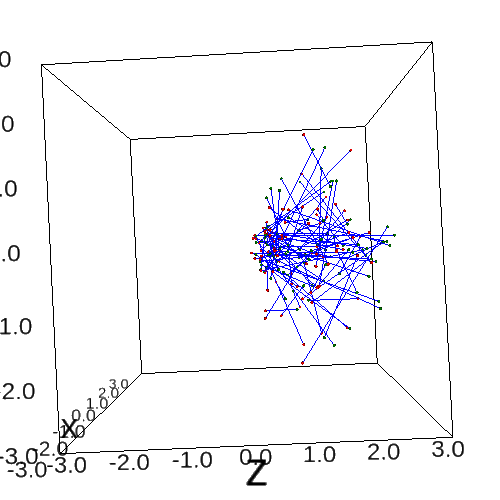

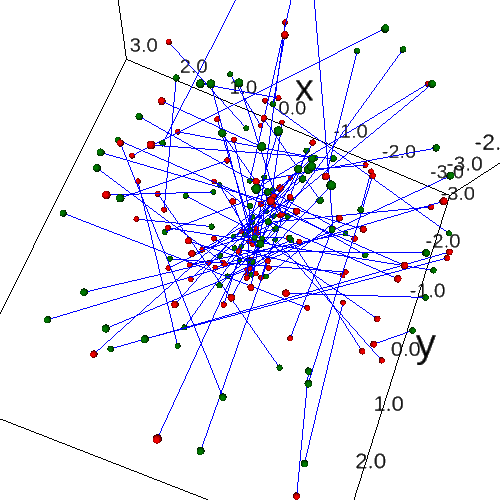

In [21]:
plot_selected_angles_with_3rd_angle_magnitude(ap, angles_true, range(100))

In [24]:
display(ipv.screenshot())

Output()

### Alignment

### Angle Alignment

In [12]:
from cryoem.angle_alignment import training_angle_alignment_R_flips, updateR_alignment

#### Quaternion Alignment

In [13]:
distance_difference(angles_predicted=ap, angles_true=angles_true)

Euclidean distance:  0.8753162350501303
Geodesic distance:  0.9354977009682132  rad ( 53.60007000967016  degrees)
Quaternion distance:  1.8792453646910081


(0.8753162350501303, 0.9354977009682132, 1.8792453646910081)

FLIPPING: (1, 1, 1)
step 300/3000 (20s): loss = 1.89e+00
step 600/3000 (42s): loss = 1.86e+00
step 900/3000 (62s): loss = 1.84e+00
step 1200/3000 (83s): loss = 1.92e+00
step 1500/3000 (104s): loss = 1.85e+00
step 1800/3000 (125s): loss = 1.92e+00
step 2100/3000 (146s): loss = 1.82e+00
step 2400/3000 (167s): loss = 1.84e+00
step 2700/3000 (188s): loss = 1.85e+00
step 3000/3000 (208s): loss = 1.84e+00
Rotation: [-0.00490297 -0.02711936  0.1426672 ];  Loss: 1.8367986426233545
FLIPPING: (1, 1, -1)
step 300/3000 (21s): loss = 1.90e+00
step 600/3000 (43s): loss = 1.85e+00
step 900/3000 (65s): loss = 1.95e+00
step 1200/3000 (87s): loss = 1.85e+00
step 1500/3000 (110s): loss = 1.86e+00
step 1800/3000 (133s): loss = 1.80e+00
step 2100/3000 (155s): loss = 1.92e+00
step 2400/3000 (177s): loss = 1.84e+00
step 2700/3000 (201s): loss = 1.89e+00
step 3000/3000 (223s): loss = 1.84e+00
Rotation: [ 1.04681434 -0.00745438  1.07037117];  Loss: 1.8383151868526857
FLIPPING: (1, -1, 1)
step 300/3000 (24s): l

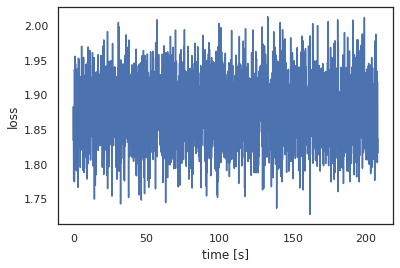

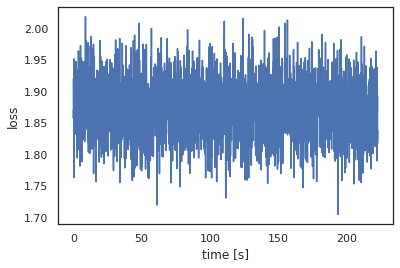

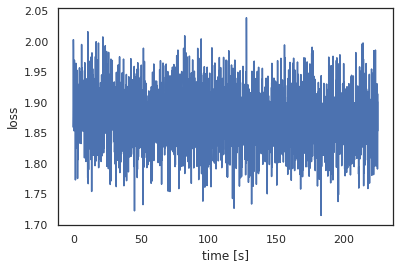

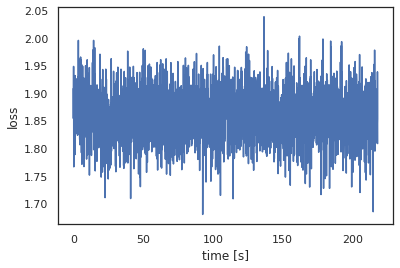

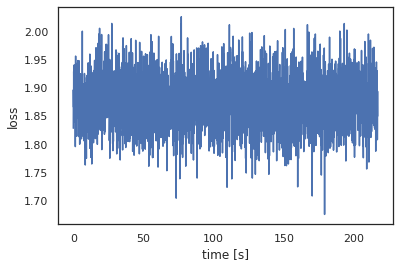

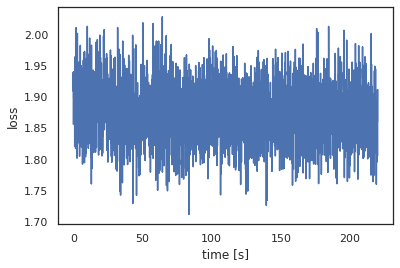

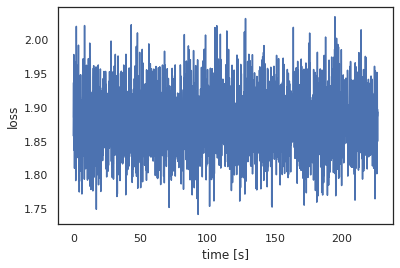

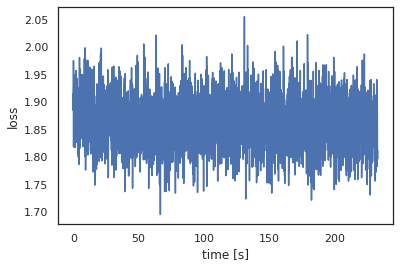

In [14]:
flips, (a_R, loss) = training_angle_alignment_R_flips(steps=3000, 
                                 batch_size=256,
                                 projection_idx=range(NUM_PROJECTIONS),
                                 learning_rate=0.01,
                                 angles_true=angles_true,
                                 ap=ap,
                                 optimization=True)

In [15]:
flips, a_R, loss

((-1, 1, -1),
 [<tf.Variable 'Variable:0' shape=(3,) dtype=float64, numpy=array([1.13859976, 0.00403881, 1.17981399])>],
 1.805538792924037)

In [16]:
angles_predicted_new = updateR_alignment(flips, ap, a_R)

In [17]:
distance_difference(angles_predicted=angles_predicted_new, angles_true=angles_true)

Euclidean distance:  0.8891816409860227
Geodesic distance:  0.9527709741869989  rad ( 54.58975566348293  degrees)
Quaternion distance:  1.8733542515433756


(0.8891816409860227, 0.9527709741869989, 1.8733542515433756)

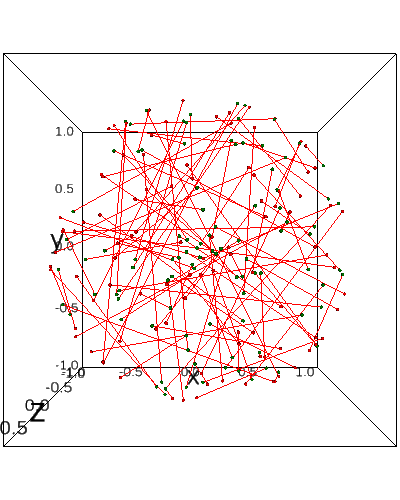

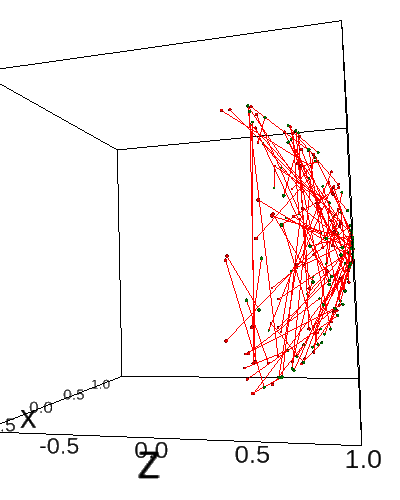

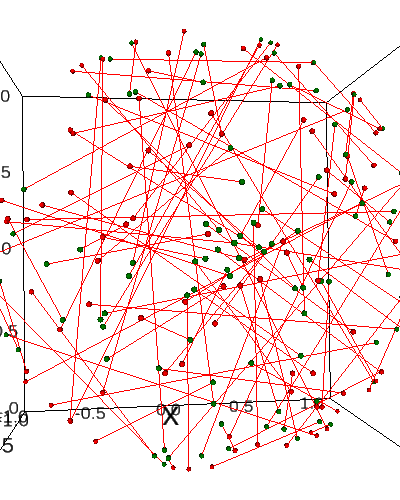

In [19]:
plot_only_selected_in_euclidean_space(angles_predicted_new, angles_true, range(100))

In [22]:
import ipyvolume as ipv

display(ipv.screenshot())

Output()

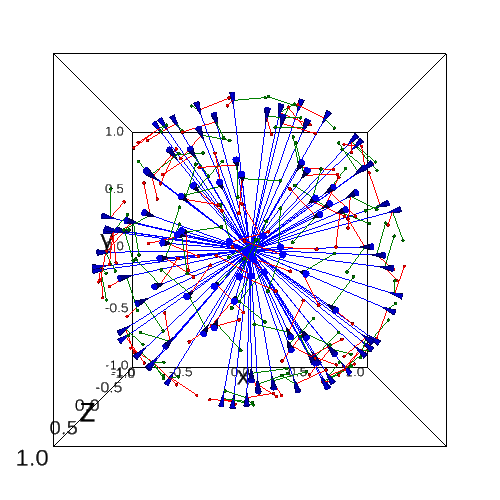

In [23]:
plot_rays(angles_predicted_new, range(100))

In [24]:
display(ipv.screenshot())

Output()

In [25]:
projections = data["Projections"]

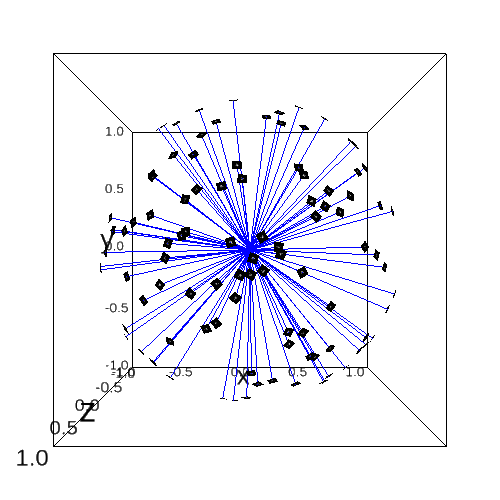

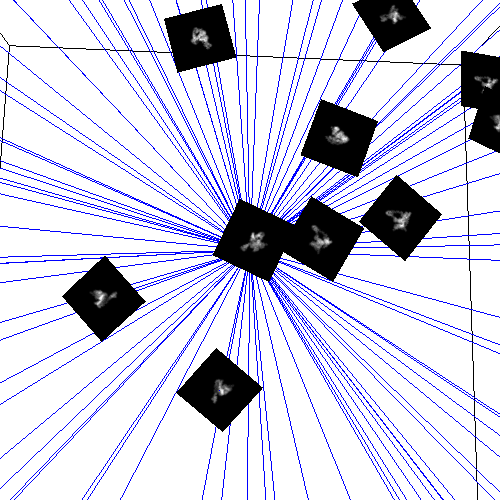

In [26]:
from cryoem.plots import plot_images
plot_images(angles_predicted_new, projections, indices=range(100),img_size_scale=0.05)

In [28]:
display(ipv.screenshot())

Output()

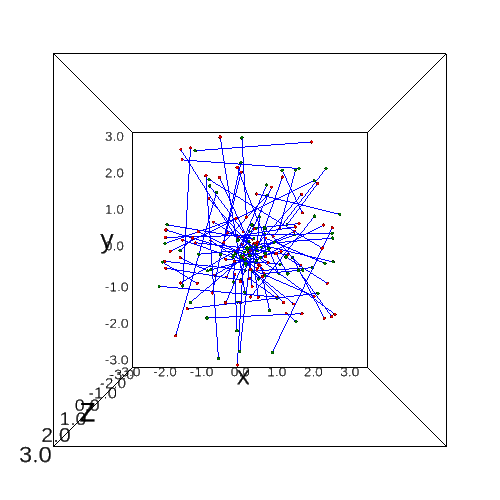

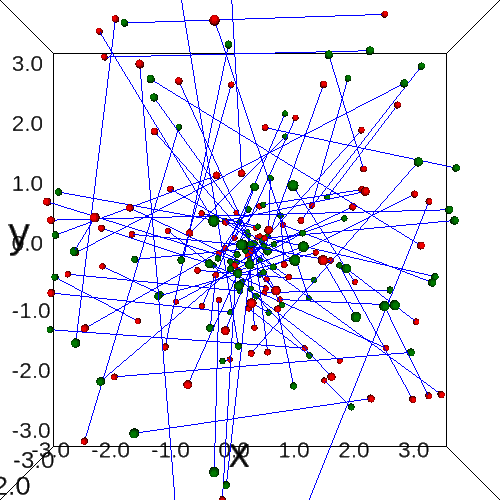

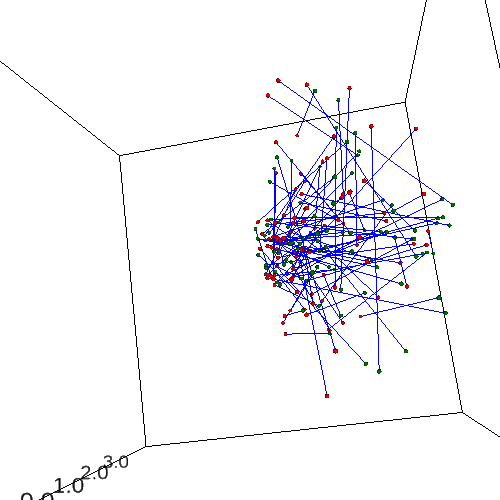

In [29]:
from cryoem.plots import plot_selected_angles_with_3rd_angle_magnitude

plot_selected_angles_with_3rd_angle_magnitude(angles_predicted_new, angles_true, range(100))

In [32]:
display(ipv.screenshot())

Output()